In [1]:
import netket as nk
import json
#from qutip import *
import numpy as np
import time
import multiprocessing as mp
from collections import OrderedDict
from pickle import dump
import os
import matplotlib.pyplot as plt
import scipy
from matplotlib import gridspec
from functools import reduce
plt.style.use('seaborn')
from scipy.stats import norm
import operator

In [2]:
def CSHam(N, B, Ak):
    # Make graph with of length N with no periodic boundary conditions
    g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
    # Spin based Hilbert Space
    hilbertSpace = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    # Define spin operators with \hbar set to 1
    sz = 0.5 * np.array([[1, 0], [0, -1]])
    sx = 0.5 * np.array([[0, 1], [1, 0]])
    sy = 0.5 * np.array([[0, -1j], [1j, 0]])
    operators = []
    sites = []
    # Central spin term
    operators.append((B * sz).tolist()) #array to list(ordered and changeable)
    sites.append([0])
    # Interaction term
    itOp = np.kron(sz, sz) + np.kron(sx, sx) + np.kron(sy, sy) #kronecker product here
    for i in range(N - 1):
        operators.append((Ak[i] * itOp).tolist())
        sites.append([0, (i+1)])  #pretty convoluted indexing, but ok
    # Create hamiltonian
    hamiltonian = nk.operator.LocalOperator(hilbertSpace, operators=operators, acting_on=sites, dtype=complex)
    #acting_on specifier necessary as this is a central spin model
    return hamiltonian, hilbertSpace

In [3]:
def exactDiagonalization(hamiltonian):
    # Changes Hamiltonian to matrix form, where hamiltonian of interest is sparse in matrix form
    #haMatrix = hamiltonian.to_sparse()
    # Gets eigenvalues and vectors, where the built-in function uses 
    eigenValues, v = nk.exact.lanczos_ed(hamiltonian, compute_eigenvectors=True)

    # Orders from smallest to largest
    eigenVectors = [v[:, i] for i in range(len(eigenValues))]
    return eigenValues, eigenVectors


In [4]:
# Error Calculation (Input: the found state, the state from exact diagonalization, the found energy, the energy from exact diagonalization)
def err(state, edState,N):
    #engErr = np.abs(eng - edEng)
    overlap = np.dot(state.conj().reshape(2**N, 1).T, edState.reshape(2**N, 1))
    waveFunctionErr = 1 - np.linalg.norm(overlap)
    return waveFunctionErr

In [7]:
#rough testing for a particular N = 3

N = 2

# Constant B
B = 0.95
    
# List of Ak
Ak = []
for i in range(N - 1):
    # Constant A
    Ak_i = 1
    Ak.append(Ak_i)
    
# Define hamiltonian and hilbert space
ha, hi = CSHam(N,B,Ak)

#Exact Diagonalization
e, v= exactDiagonalization(ha)
#Ground state energy
edEng = e[0]
# Ground state
edState = v[0]

print(edEng,edState)



-0.939655711206687 [-5.83729809e-17+7.17493793e-18j -3.74375101e-01+1.24372637e-01j
  8.72036199e-01-2.89702604e-01j  2.51763501e-17+8.76660112e-18j]


So the numerical exact diagnolization method works, let's now try the analytic method

In [9]:
def u(ms,A,B):
    u = 0.5*B+0.5*A*ms
    return u

def g(ms,A,B,s):
    g = 0.5*A*np.sqrt(s*(s+1)-ms*(ms+1))
    return g

def analytic(N,A,B):
    s = float((N-1)/2)
    m_s = np.arange(-s,s+0.1,step=1)
    ms=[]
    for x in range(0,len(m_s)-1,1):
        ms.append(m_s[x])
    eigvec = []
    eigval = []
    for i in range(len(ms)):
        matrix = np.array([[u(ms[i],A,B),g(ms[i],A,B,s)],[g(ms[i],A,B,s),-u(ms[i]+1,A,B)]])
        val,vec = np.linalg.eigh(matrix)
        #we want m_j immediately after the doublets
        eigvec.append(vec)
        eigvec.append(ms[i]+0.5)
        eigval.append(val.tolist())
        #eigval.append(ms[i]+0.5)
    #in the end, we append the two trivial solutions
    #eigvec.append([1],N/2,[-1],-N/2)
    #eigval.append()
    return eigvec, eigval

    
    
        
    
    
        
        
    

In [11]:
analytic(3,1,B)

([array([[-0.81649658, -0.57735027],
         [ 0.57735027, -0.81649658]]),
  -0.5,
  array([[-0.57735027, -0.81649658],
         [ 0.81649658, -0.57735027]]),
  0.5],
 [[-1.0, 0.5000000000000001], [-1.0, 0.5000000000000001]])

[array([1.11022302e-16]), array([4.4408921e-16]), array([1.55431223e-15]), array([2.66453526e-15]), array([2.66453526e-15]), array([5.32907052e-15]), array([7.99360578e-15]), array([4.4408921e-15]), array([6.21724894e-15]), array([1.77635684e-15]), array([8.8817842e-15]), array([7.99360578e-15]), array([5.32907052e-15]), array([6.21724894e-15]), array([7.99360578e-15]), array([8.8817842e-15]), array([7.99360578e-15]), array([8.8817842e-16])] [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


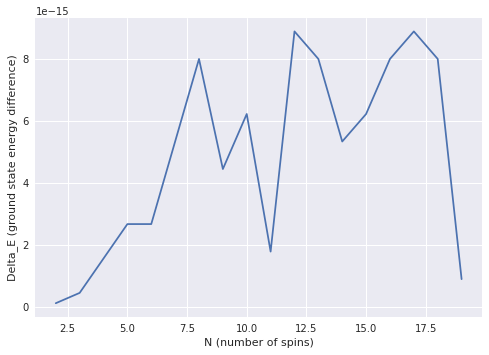

In [65]:
NN = 20 #number of spins-1
B=1
del_eig = []
N_list = []

for i in range(2,NN,1):
    #flatten the list of eigenvalues
    list_flat = reduce(operator.iconcat, analytic(i,A,B)[1], []) 
    e_an = min(list_flat)
    
    #loop for Ak
    Ak = []
    for j in range(i):
    # Constant A
        Ak_j = 1
        Ak.append(Ak_j)
        
    ha, hi = CSHam(i,B,Ak)
    e_num =  exactDiagonalization(ha)[0]
    #get the ground state energy difference
    del_e = np.abs(e_num-e_an)
    del_eig.append(del_e)
    N_list.append(i)

print(del_eig,N_list)

plt.plot(N_list,del_eig)
plt.xlabel('N (number of spins)')
plt.ylabel('Delta_E (ground state energy difference)')
plt.show()

Now let's do ground state vector, N=2,3,4

In [99]:
err_state = []
#N=2
v2 = np.array(exactDiagonalization(ha)[1])
v2_a = np.array([0, 0.70710678,-0.70710678,0])
a = err(v2,v2_a,2)
err_state.append(a)

#N=3
v3 = np.array(exactDiagonalization(ha)[1])
v3_a = np.array([0, 0.70710678,-0.70710678,0])

#incomplete as degeneracy comes up N=3, A=1, B=0

1.6780317135811629e-09
